In [ ]:
using CausalityTools
include("../entropy.jl")
using Random
using BenchmarkTools

rng = MersenneTwister(145)

a = rand(rng, 0:10, 100)
b = rand(rng, 0:10, 100)

est = Kraskov(k=1)

print("Current method :")
foo = @btime TE(Int.(a .> 0), Int.(b .> 0))
println("The result is $foo.\n")


print("True transfer entropy :")
a = float.(a)
b = float.(b)
foo2 = @btime transferentropy(a, b, est)
println("The result is $foo2.\n")

print("CCM :")
foo3 = @btime crossmap(a, b, 2, 1)
println("The result is $foo3.\n")

In [ ]:
import PyPlot as plt

rng = MersenneTwister(145)

a = rand(rng, 0:10, 100)
b = rand(rng, 0:10, 100)

a = float.(a)
b = float.(b)

Ls = [10:5:50; 60:10:100]

@btime begin
    test = [crossmap(a[1:L], b[1:L], 2, 1) for L in Ls]
    test2 = [crossmap(b[1:L], a[1:L], 2, 1) for L in Ls]
end

plt.figure()
plt.plot(Ls, test, "b-", label="a to b")
plt.plot(Ls, test2, "r-", label="b to a")
plt.legend()
show(plt.gcf())

In [ ]:
using CausalityTools

s_measure()

In [ ]:
using CausalityTools

# A two-dimensional Ulam lattice map
sys = ulam(2)

# Sample 1000 points after discarding 5000 transients
orbit = trajectory(sys, 1000, Ttr = 5000)
x, y = orbit[:, 1], orbit[:, 2]

# 4-dimensional embedding for `x`, 5-dimensional embedding for `y`
s_measure(x, y, dx = 4, τx = 3, dy = 5, τy = 1)

In [ ]:
using DelayEmbeddings

a = collect(1:100)
p = embed(a, 2, 5)

In [ ]:
using Neighborhood

a = [0, 1.2, 0.1, 0.8]
b = [0, 0, 1.8, 0.8]


X = embed(a, 2, 1)
Y = embed(b, 2, 1)

treeX = searchstructure(KDTree, X, Euclidean())
treeY = searchstructure(KDTree, Y, Euclidean())
neighborhoodtype, theiler = NeighborNumber(1), Theiler(0)
idxs_X = bulkisearch(treeX, X, neighborhoodtype, theiler)
idxs_Y = bulkisearch(treeY, Y, neighborhoodtype, theiler)

print(idxs_Y)

In [ ]:
using CausalityTools
using BenchmarkTools

include("../Utils/entropy.jl")

x = rand(0:10, 50)
y = rand(0:10, 50)

@btime s_measure(float(x), float(y), K=3, dx=5, dy=5, τx=1, τy=1)

@btime TE(Int.(x .> 0), Int.(y .> 0))

In [ ]:
using HypothesisTests

x = rand(0:10, 50)
y = rand(0:10, 50)

@btime jdd(OneSampleTTest, x, y, B=10, D=2, τ=1)

In [ ]:
source = collect(1:5)
target = collect(11:15)

D = 2
B = 10
τs = 1

@btime Ex = DelayEmbeddings.embed(source, D, τs)
Ey = DelayEmbeddings.embed(target, D, τs)
Mx = DelayEmbeddings.Matrix(Ex)
My = DelayEmbeddings.Matrix(Ey)

In [ ]:
import DelayEmbeddings

source = collect(1:5)
target = collect(11:15)

D = 2
B = 10
τ = 1

js = ([1 for i = 1:D]...,)
τs = (collect(0:-τ:-(D-1)*τ)...,)

Ex = DelayEmbeddings.genembed(source, τs, js)
Ey = DelayEmbeddings.genembed(target, τs, js)
Mx = DelayEmbeddings.Matrix(Ex)
My = DelayEmbeddings.Matrix(Ey)

In [ ]:
Matrix(Ex) 

In [ ]:
foo = [0 1; 2 0]
LinearIndices(foo[foo .> 0])

In [ ]:
My

In [ ]:
Mx

In [ ]:
using Distances

pairwise(Euclidean(), Mx, Mx, dims=1)

In [ ]:
Euclidean()([2,1], [3,2])

In [ ]:
using BenchmarkTools
using CausalityTools

include("../Utils/entropy.jl")

B = 10
d = 3
τ = 1
alpha = 0.001

K = 3
dx = 3
dy = 3
τx = 1
τy = 1

cuttoff = 0.5
cuttoff2 = 0.01

func1(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0
func2(x, y) = TE(Int.(x .> 0), Int.(y .> 0)) > cuttoff ? 1 : 0
func3(x,y) = s_measure(float(x), float(y), K=K, dx=dx, dy=dy, τx=τx, τy=τy) > cuttoff2 ? 1 : 0

tot1 = 0
tot2 = 0
tot3 = 0
nans = 0
for i = 1:100
    x = rand(0:10, 30)
    y = rand(0:10, 30)

    tot1 += func1(x ,y)
    tot2 += func2(x ,y)
    tot3 += func3(x ,y)
end

println("jdd : $tot1")
println("TE : $tot2")
println("s measure : $tot3")

In [ ]:
using BenchmarkTools
using CausalityTools

B = 10
d = 3
τ = 1
alpha = 0.001

cuttoff = 0.5
cuttoff2 = 0.01

func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0

tot = 0

for i = 1:1000
    x = rand(0:10, 1000)
    y = rand(0:10, 1000)

    tot += func(x ,y)
end

println("jdd : $tot")

In [ ]:
using BenchmarkTools
using CausalityTools
using StatsBase

function normalize(x)
    return (x .- mean(x))/std(x)
end


B = 10
d = 3
τ = 1
alpha = 0.001

Nsurr = 50
p_value_surr = Vector{Float64}(undef, Nsurr)

func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right)

tot = 0
eviter = 0

for i = 1:1000
    x = rand(0:10, 100)
    y = rand(0:10, 100)

    p = func(x, y)

    if p < alpha

        s = surrogenerator(x, RandomShuffle())

        for i = 1:Nsurr
            p_value_surr[i] = func(s(), y)
            # p_value_surr[i] = func(rand(0:10, 100), y)
        end

        limit = quantile(p_value_surr, 0.01)/4
        limit2 = minimum()

        if p < limit
            tot += 1
            println("p : $p    limit: $limit     limit2: $(limit2)")

        else
            eviter += 1
        end

    end

    #= if p < alpha
        tot += 1
    end =#

end

println("jdd : $tot")
println("We removed : $eviter")

In [ ]:
println(quantile(p_value_surr, 0.01)/4)
println(quantile(p_value_surr, 0.05)/4)
confint(OneSampleTTest(p_value_surr), 0.0001)

In [ ]:
x = 1:100
y = 101:200

p = func(x, y)

if p < alpha

    s = surrogenerator(x, RandomShuffle())

    for i = 1:Nsurr
        p_value_surr[i] = func(s(), y)
        # p_value_surr[i] = func(rand(0:10, 100), y)
    end

    limit = minimum(p_value_surr)/2 #quantile(p_value_surr, 0.05)

    println("p : $p    limit: $limit")

    if p < limit
        tot += 1
    end

end

In [ ]:
import PyPlot as plt
using Distributions

foo = fit_mle(Normal, p_value_surr)


show(plt.hist(p_value_surr, bins=20))
plt.plot(0:0.001:0.3, rand(foo, length(0:0.001:0.3)), "-r")
foo

In [ ]:
float.(p_value_surr)

In [ ]:
d = Normal()
x = rand(d, 100)



In [ ]:
mean(p_value_surr) - std(p_value_surr)

In [ ]:
using CausalityTools

a = collect(1:30)
b = collect(51:80)

a = [[0 for i in 1:30]..., a...]
b = [[0 for i in 1:30]..., b...]

B = 10
d = 3
τ = 5
alpha = 0.001

func(x,y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right)
func(a, b)

In [ ]:
func2(x, y) = TE(Int.(x .> 0), Int.(y .> 0))

nans = 0
for i = 1:100
    x = rand(0:10, 100)
    y = rand(0:10, 100)

    isnan(func2(x,y)) ? nans += 1 : nans += 0
end

nans

In [ ]:
x = rand(0:10, 30)
y = rand(0:10, 30)

B = 10
d = 3
τ = 1
alpha = 0.001

func1(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0
@btime func1(x,y)

In [ ]:
foo = zeros(3,3)
try
    a = minimum(foo[foo .> 0])
catch
    print("foo")
end

In [ ]:
est = VisitationFrequency(RectangularBinning(10))

n = 1000
# Source and target variables
s, t = rand(n), rand(n)


est = NaiveKernel(0.3)
@btime bbnue(s, t, est)

In [ ]:
using CausalityTools

a = float([[0 for i = 1:24]..., 1, [0 for i = 1:75]...])
b = float([[0 for i = 1:36]..., 1, [0 for i = 1:63]...])

a = (a .- mean(a)) / std(a)
b = (b .- mean(b)) / std(b)

transferentropy(a, b, Kraskov(k=3))

In [ ]:
using Dates

start_time = DateTime(2021, 10, 11, 13, 23, 12) 
end_time = DateTime(2021, 10, 28, 23, 29, 13) 
time_interval = Day(1)

println(floor(start_time, time_interval))
println(ceil(end_time, time_interval))

In [ ]:
start_time = DateTime(2021, 10, 11, 13, 23, 12) 
end_time = DateTime(2021, 10, 28, 23, 29, 13) 
time_interval = Day(1)

function create_time_intervals(start_time::DateTime, end_time::DateTime, time_interval::Period)

    # Set beginning and end of interval by rounding
    start_time = floor(start_time, time_interval)
    end_time = ceil(end_time, time_interval)

    intervals = [start_time]
    
    if end_time - start_time > time_interval
        start = start_time
        while start + time_interval < end_time
            push!(intervals, start + time_interval)
            start += time_interval
        end
    end
            
    push!(intervals, end_time)
    
    return intervals


end

create_time_intervals(start_time, end_time, time_interval)

start_time

In [ ]:
Minute <: Period

In [ ]:
using DataFrames
using Dates
include("../Utils/Helpers.jl")
using .Helpers

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

In [ ]:
start_time = minimum(data.created_at)
println(start_time)
println(floor(start_time, Minute))

In [ ]:
end_time = maximum(data.created_at)
println(end_time)
println(ceil(end_time, Minute))

In [ ]:

start_time = minimum(data.created_at)
end_time = maximum(data.created_at)
time_interval = Hour(5)

function create_time_intervals(start_time::DateTime, end_time::DateTime, time_interval::Period)

    # Set beginning and end of interval by rounding
    start_time = floor(start_time, Minute)
    end_time = ceil(end_time, Minute)

    intervals = [start_time]
    
    if end_time - start_time > time_interval
        start = start_time
        while start + time_interval < end_time
            push!(intervals, start + time_interval)
            start += time_interval
        end
    end
            
    push!(intervals, end_time)
    
    return intervals


end

foo = create_time_intervals(start_time, end_time, time_interval)

In [ ]:
length(foo) - 1

In [ ]:
total_min = 5*60

clean_dates = x -> floor(x, Dates.Minute(total_min))
data.time = clean_dates.(data."created_at")

In [ ]:
a = Vector{Int}(undef, 2)

In [ ]:
isassigned(a, 3)

In [ ]:
using DataFrames
using Dates
include("../Utils/Helpers.jl")
using .Helpers
include("../Sensors/Sensors.jl")
import .Sensors as sen

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");



In [ ]:
foo = x -> floor(x, Minute)
time = foo.(data.created_at)

In [ ]:
println(length(unique(time)))
println(24*60*39)


In [ ]:
13*24/2

In [5]:
5 ÷ 2

2

In [3]:
isodd(3)

true

PyPlot.Figure(PyObject <Figure size 640x480 with 1 Axes>)

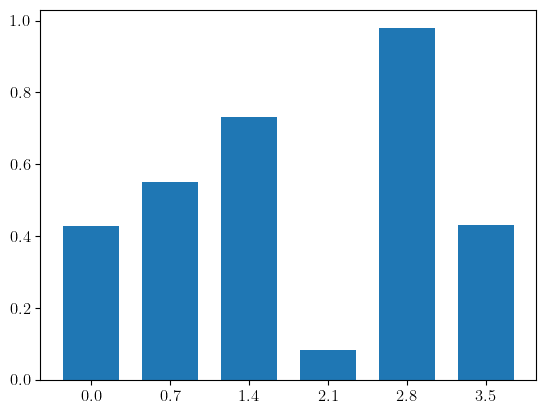

In [27]:
include("../Sensors/Sensors.jl")
include("../Utils/Visualizations.jl")
using .Visualizations;
import PyPlot as plt

Nbar = 1
x_length = 6
width = 0.5
spacing = 0.2

Y = rand(Nbar, x_length)
X, ticks = Visualizations.barplot_layout(Nbar, x_length, width=width, spacing=spacing)

plt.figure()
for i = 1:Nbar
    plt.bar(X[i, :], Y[i, :], width=width, label="$i", zorder=2)
end
plt.xticks(ticks)
show(plt.gcf())

In [30]:
x = rand(4)
[x... [0. for i = 1:3]...]

1×7 Matrix{Float64}:
 0.535588  0.496839  0.296448  0.322843  0.0  0.0  0.0

In [17]:
using Revise
include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

a = [0.1 0.2;0.05 0.2]
b = [0.8 0.2;0.6 0.1]
c = [0.1 0.2;0.2 0]
d = [0.9 0.2;0.6 0.7]
e = [0 0;0 0]

B = Matrix{Matrix{Float64}}(undef, 3, 3)

B[1,1] = e
B[1,2] = b
B[1,3] = e
B[2,1] = e
B[2,2] = e
B[2,3] = d
B[3,1] = e
B[3,2] = e
B[3,3] = e

cuttoff = 0.5
icg = InfluenceCascadeGenerator(cuttoff, false)

cascades_A = observe(B, icg)

1-element Vector{InfluenceCascade}:
 InfluenceCascade(OrderedDict{AbstractString, Matrix}("0 => 1" => [0.8 0.0; 0.6 0.0], "1 => 2" => [0.9 0.0; 0.6 0.7]), OrderedDict{AbstractString, Vector{Tuple{Int64, Int64}}}("0 => 1" => [(1, 2)], "1 => 2" => [(2, 3)]), [1, 1, 1], 1, false)

In [16]:
B

3×3 Matrix{Matrix{Float64}}:
 [0.0 0.0; 0.0 0.0]  [0.8 0.2; 0.6 0.1]  [0.0 0.0; 0.0 0.0]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]  [0.9 0.2; 0.6 0.7]
 [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]  [0.0 0.0; 0.0 0.0]

In [28]:
include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

f = [1.2 0.3 0.; 0.7 0.3 0.3; 0. 0.6 0.]
g = [0.3 0.3 0.3; 0.2 0.9 0.8; 0.3 0.9 0.]
h = zeros(3,3)

C = Matrix{Matrix{Float64}}(undef, 4, 4)

for i in 1:size(C,1), j in 1:size(C,2)
    C[i,j] = h
end

C[1, 4] = f
C[2,1] = g
C[3,4] = f
C[4,1] = g

D = Matrix{Matrix{Float64}}(undef, 4, 4)

for i in 1:size(C,1), j in 1:size(C,2)
    D[i,j] = h
end

D[1, 2] = f
D[1, 4] = f
D[2,3] = g
D[3,2] = f
D[4,2] = g

cuttoff = 0.5
icg = InfluenceCascadeGenerator(cuttoff, false)

cascades = observe(D, icg)
println(cascades[1].actor_edges)
println(cascades[1].actors_per_level)

OrderedDict{AbstractString, Vector{Tuple{Int64, Int64}}}("0 => 1" => [(1, 2), (1, 4)], "1 => 2" => [(2, 3), (4, 2)], "2 => 3" => [(3, 2)])
[1, 2, 2, 1]


In [26]:
println(cascades[2].actor_edges)
println(cascades[2].actors_per_level)

OrderedDict{AbstractString, Vector{Tuple{Int64, Int64}}}("0 => 1" => [(3, 4)], "1 => 2" => [(4, 1)], "2 => 3" => [(1, 4)])
[1, 1, 1, 1]
